## This dataset contains detailed hospital encounter information for ~70,000 diabetic patients, including demographics, diagnoses, lab results, medications, and readmission outcomes, enabling comprehensive analysis of hospital care patterns and prediction of readmission risk.


###  each patient, the hospital records:
1. Who the patient is
- Age
- Gender
- Race
2. Why they came to the hospital
- Primary diagnosis (heart issue, respiratory issue, diabetes, injury, etc.)
- Secondary diagnoses
3. What happened during the hospital stay
- Lab tests
- Medications
- Procedures
- How long they stayed
- Whether their diabetes medications changed
- Whether HbA1c was measured
4. Their past health usage
- How many times they visited outpatient, emergency, or inpatient departments in the last year
5. How they left the hospital
- Discharged home
- Sent to rehab
- Transferred
- Etc.
6. Did they come back again?
This is the key outcome:
- <30 days
- >30 days
- No readmission
This is the main target for prediction


##  Why this dataset exists
Hospitals wanted to understand:
- Why do some diabetic patients get readmitted quickly?
- Does measuring HbA1c help reduce readmissions?
- Do certain diagnoses lead to higher readmission risk?
- Do medication changes matter?
The dataset was created to answer these questions.


In [6]:
with open(r"D:\HealthCare System\IDS_mapping.csv", "r") as f:
    lines = f.read().splitlines()



In [7]:
idx_admission_type = lines.index("admission_type_id,description")
idx_discharge = lines.index("discharge_disposition_id,description")
idx_admission_source = lines.index("admission_source_id,description")


In [8]:
admission_type_map = pd.read_csv(
    r"D:\HealthCare System\IDS_mapping.csv",
    skiprows=idx_admission_type,
    nrows=idx_discharge - idx_admission_type - 1
)
admission_type_map.columns = ["admission_type_id", "admission_type_desc"]


In [9]:
discharge_map = pd.read_csv(
    r"D:\HealthCare System\IDS_mapping.csv",
    skiprows=idx_discharge,
    nrows=idx_admission_source - idx_discharge - 1
)
discharge_map.columns = ["discharge_disposition_id", "discharge_desc"]


In [10]:
admission_source_map = pd.read_csv(
    r"D:\HealthCare System\IDS_mapping.csv",
    skiprows=idx_admission_source
)
admission_source_map.columns = ["admission_source_id", "admission_source_desc"]


In [11]:
df = df.merge(admission_type_map, on="admission_type_id", how="left")
df = df.merge(discharge_map, on="discharge_disposition_id", how="left")
df = df.merge(admission_source_map, on="admission_source_id", how="left")


## The paper itself recommends removing:
- weight → 97% missing
- payer_code → 40% missing
- medical_specialty → 47% missing ( can keep or drop)


In [17]:
df = df.replace("?", pd.NA)


In [12]:
df = df.drop(['weight', 'payer_code'], axis=1)


In [13]:
df['medical_specialty'] = df['medical_specialty'].fillna("Missing")


## Drop ID columns that don’t help modeling

In [14]:
df = df.drop(['encounter_id', 'patient_nbr'], axis=1)


## The target is readmitted.
 can keep it as 3‑class:
- <30
- >30
- NO



In [15]:
df['readmitted_binary'] = df['readmitted'].apply(lambda x: 1 if x=='<30' else 0)


In [16]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in df.select_dtypes(include='object').columns:
    df[col] = le.fit_transform(df[col].astype(str))


EDA

In [18]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype
---  ------                    --------------   -----
 0   race                      101766 non-null  int64
 1   gender                    101766 non-null  int64
 2   age                       101766 non-null  int64
 3   admission_type_id         101766 non-null  int64
 4   discharge_disposition_id  101766 non-null  int64
 5   admission_source_id       101766 non-null  int64
 6   time_in_hospital          101766 non-null  int64
 7   medical_specialty         101766 non-null  int64
 8   num_lab_procedures        101766 non-null  int64
 9   num_procedures            101766 non-null  int64
 10  num_medications           101766 non-null  int64
 11  number_outpatient         101766 non-null  int64
 12  number_emergency          101766 non-null  int64
 13  number_inpatient          101766 non-null  int64
 14  diag_1              

In [19]:
df.describe()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,...,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admission_type_desc,discharge_desc,admission_source_desc,readmitted_binary
count,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,...,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,2.598776,0.462443,6.096702,2.024006,3.715642,5.754437,4.395987,11.708871,43.095641,1.339730,...,0.000010,0.000020,0.000010,0.538048,0.770031,1.427520,2.138897,4.555117,3.987560,0.111599
std,0.938415,0.498649,1.594084,1.445403,5.280166,4.064081,2.985108,17.507131,19.674362,1.705807,...,0.003135,0.004433,0.003135,0.498553,0.420815,0.684068,2.349403,6.157371,4.506454,0.314874
min,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,5.000000,1.000000,1.000000,1.000000,2.000000,0.000000,31.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
50%,3.000000,0.000000,6.000000,1.000000,1.000000,7.000000,4.000000,4.000000,44.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,0.000000
75%,3.000000,1.000000,7.000000,3.000000,4.000000,7.000000,6.000000,19.000000,57.000000,2.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000,3.000000,7.000000,5.000000,0.000000
max,5.000000,2.000000,9.000000,8.000000,28.000000,25.000000,14.000000,72.000000,132.000000,6.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,7.000000,25.000000,16.000000,1.000000


## Check missing values

In [20]:
df.isna().sum()


race                        0
gender                      0
age                         0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
medical_specialty           0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazone                0
rosiglitazone               0
acarbose                    0
miglitol                    0
troglitazo

## Target variable distribution

<Axes: xlabel='readmitted'>

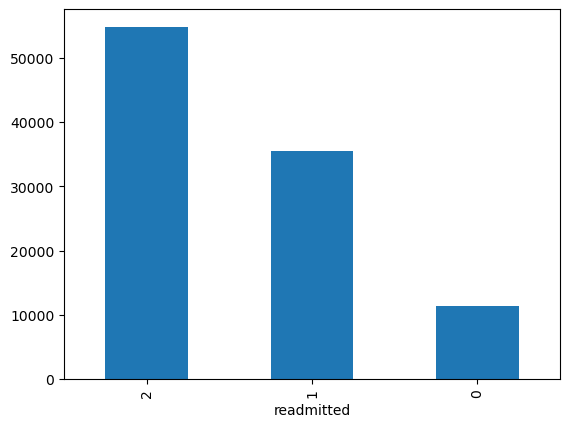

In [21]:
df['readmitted'].value_counts().plot(kind='bar')


## Length of stay

<Axes: ylabel='Frequency'>

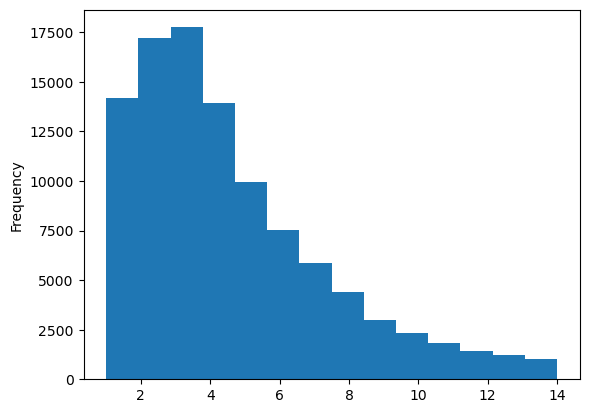

In [22]:
df['time_in_hospital'].plot(kind='hist', bins=14)


## Lab tests & medication

<Axes: ylabel='Frequency'>

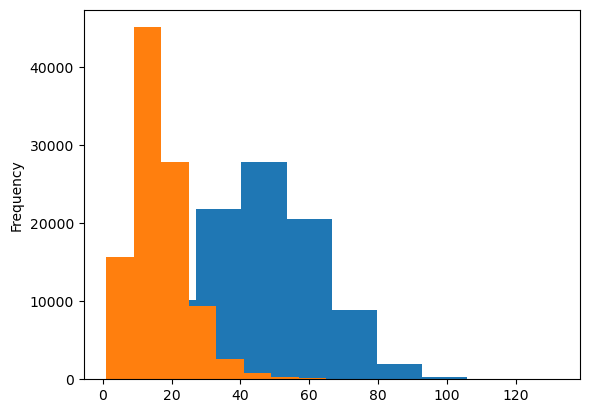

In [23]:
df['num_lab_procedures'].plot(kind='hist')
df['num_medications'].plot(kind='hist')


## Readmission vs A1C result

In [24]:
df.groupby('A1Cresult')['readmitted'].value_counts(normalize=True)


A1Cresult  readmitted
0          2             0.558499
           1             0.341028
           0             0.100472
1          2             0.548199
           1             0.353092
           0             0.098710
2          2             0.582966
           1             0.320441
           0             0.096593
3          2             0.534785
           1             0.350982
           0             0.114233
Name: proportion, dtype: float64

<Axes: >

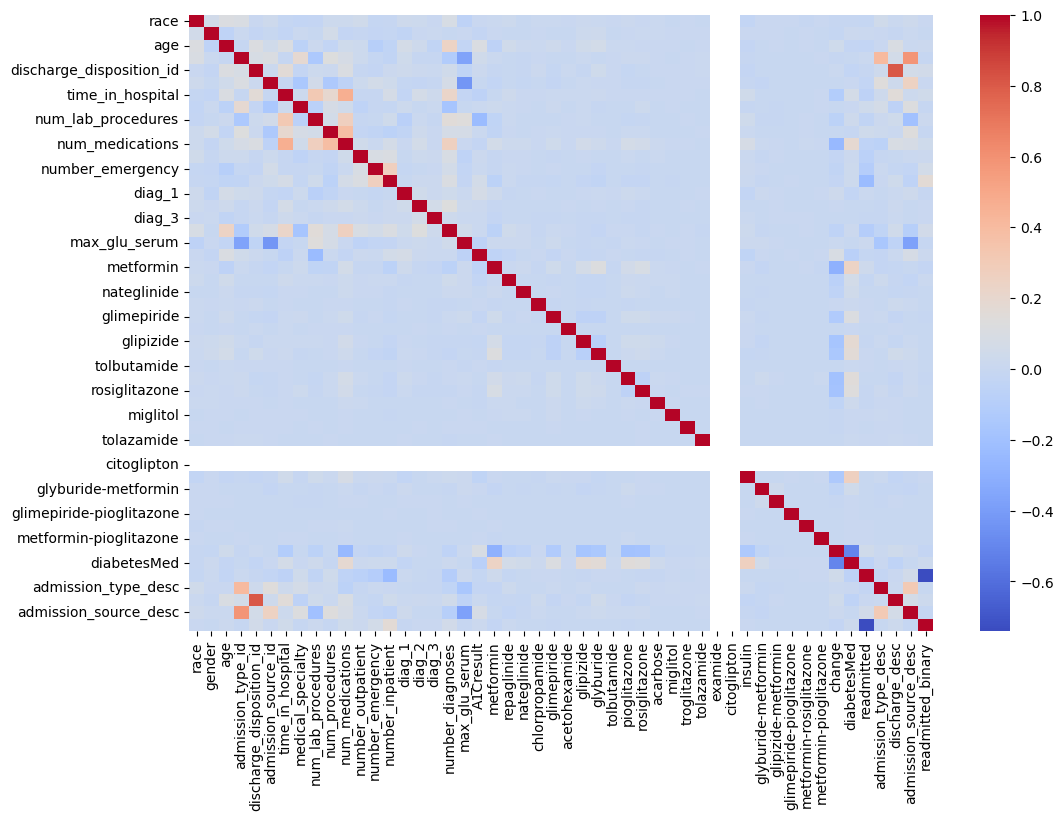

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), cmap='coolwarm')


In [26]:
df.to_csv(r"D:\HealthCare System\diabetic_data_cleaned.csv", index=False)